<a href="https://colab.research.google.com/github/NadeemMughal/Langgraph/blob/main/LLM_To_Email_Langgraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langchain_core langgraph langchain_google_genai

In [ ]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
model: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model = "gemini-2.0-flash", api_key=GEMINI_API_KEY)
model.invoke("hello")

AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-f79acf7e-18b7-4455-81e8-d62b43093f0f-0', usage_metadata={'input_tokens': 1, 'output_tokens': 10, 'total_tokens': 11, 'input_token_details': {'cache_read': 0}})

In [ ]:
from langgraph.graph import MessagesState

class State(MessagesState):
    pass

In [ ]:
from langchain_core.messages import SystemMessage

sys_prompt_classify = SystemMessage(content= """
    Your work is too clasify either this email content is related to Complain, any updation, want to schedule a meeting or
    it's a general query? If user query related to Complain then return just "complain", if user query related to Meeting or want to discuss something new on call then return "meeting",
    if user query related to updation of anything then return "updation",  or if user query related to General type of query then return "general".
    ## Rules
    analyze the email content efficiently then give the response.
    ## return
    Always return just 1 word and lowercase.
    """)
sys_prompt_complain = SystemMessage(content= """Your work is too check from retrival and answer this on the base of knowledge base and user question. or simply says your complain has been registered""")
sys_prompt_meeting = SystemMessage(content= """Your work is too say your appointment has been booked. """)
sys_prompt_updation = SystemMessage(content= """Your work is too say ok, i'll upate it and get back to you as soon as possible. """)
sys_prompt_general_query = SystemMessage(content= """Your work is too say i am a assistant of we build trade one of our team member will reach out you soon and answer your query as best.""")
sys_email_prompt = """
You are an AI assistant tasked with generating professional email responses.
Based on the following content, please compose a polite and concise email response:

{content}
"""



##### For Classify Agent

In [ ]:
from langchain_core.messages import HumanMessage,AIMessage
from langchain_core.messages import SystemMessage

def classify_agent(state: MessagesState) -> str:
    """
    Function to classify a user query using a system prompt and the ChatGoogleGenerativeAI model.

    Args:
        sys_prompt_classify (str): The system prompt to guide the model's behavior.
        user_query (str): The user's query to be classified.

    Returns:
        str: The model's response to the user query.
    """
    sys_prompt_classify = [SystemMessage(content= """
    Your work is too clasify either this email content is related to Complain, any updation, want to schedule a meeting or
    it's a general query? If user query related to Complain then return just "complain", if user query related to Meeting or want to discuss something new on call then return "meeting",
    if user query related to updation of anything then return "updation",  or if user query related to General type of query then return "general".
    ## Rules
    analyze the email content efficiently then give the response.
    ## return
    Always return just 1 word and lowercase.
    """)]
    #The state dictionary stores messages under the key "messages"
    state1=state["messages"]
    # # Initialize the message state with the system prompt and user query
    # initial_messages = [
    #     SystemMessage(content=sys_prompt_classify),
    #     HumanMessage(content=user_query)
    # ]
    m = sys_prompt_classify + state1

    # Invoke the model with the current state messages
    response = model.invoke(m)

    # Append the AI's response to the message state
    state.messages.append(AIMessage(content=response.content))

    # Return the AI's response content
    return response.content

In [ ]:
workflow = StateGraph(state_schema=MessagesState)
workflow.add_edge(START, "model")
workflow.add_node("model", classify_agent)
app = workflow.compile()

In [ ]:
query = "Hi! I'm Bob."

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages})
output["messages"][-1].pretty_print()

AttributeError: 'dict' object has no attribute 'messages'

##### For Complain Agent

In [ ]:
def complaint_agent(state: MessagesState, sys_prompt_complain: str, user_query: str) -> str:
    """
    Handles user complaints by processing the user query with a system prompt and updating the conversation state.

    Args:
        state (MessagesState): The current conversation state containing the message history.
        sys_prompt_complain (str): The system prompt guiding the model's behavior for complaint handling.
        user_query (str): The user's complaint query.

    Returns:
        str: The model's response to the user's complaint.
    """
    # Append the system prompt and user query to the message history
    state.messages.append(SystemMessage(content=sys_prompt_complain))
    state.messages.append(HumanMessage(content=user_query))

    # Invoke the model with the updated message history
    response = model.invoke(state.messages)

    # Append the AI's response to the message history to maintain context
    state.messages.append(AIMessage(content=response.content))

    # Return the AI's response content
    return response.content



##### For Meeting

In [ ]:
def meeting_agent(state: MessagesState, sys_prompt_meeting: str, user_query: str) -> str:
    """
    Processes meeting-related user queries, updates the conversation state, and returns the model's response.

    Args:
        state (MessagesState): The current conversation state containing the message history.
        sys_prompt_meeting (str): The system prompt guiding the model's behavior for meeting-related queries.
        user_query (str): The user's query related to meetings.

    Returns:
        str: The model's response to the user's meeting-related query.
    """
    # Append the system prompt and user query to the message history
    state.messages.append(SystemMessage(content=sys_prompt_meeting))
    state.messages.append(HumanMessage(content=user_query))

    # Invoke the model with the updated message history
    response = model.invoke(state.messages)

    # Append the AI's response to the message history to maintain context
    state.messages.append(AIMessage(content=response.content))

    # Return the AI's response content
    return response.content


##### For Updation Agent

In [ ]:

def update_agent(state: MessagesState, sys_prompt_update: str, user_query: str) -> str:
    """
    Processes update-related user queries, updates the conversation state, and returns the model's response.

    Args:
        state (MessagesState): The current conversation state containing the message history.
        sys_prompt_update (str): The system prompt guiding the model's behavior for update-related queries.
        user_query (str): The user's query related to updates.

    Returns:
        str: The model's response to the user's update-related query.
    """
    # Append the system prompt and user query to the message history
    state.messages.append(SystemMessage(content=sys_prompt_updation))
    state.messages.append(HumanMessage(content=user_query))

    # Invoke the model with the updated message history
    response = model.invoke(state.messages)

    # Append the AI's response to the message history to maintain context
    state.messages.append(AIMessage(content=response.content))

    # Return the AI's response content
    return response.content


##### For General Query

In [ ]:
def general_agent(state: MessagesState, sys_prompt_general: str, user_query: str) -> str:
    """
    Processes general user queries, updates the conversation state, and returns the model's response.

    Args:
        state (MessagesState): The current conversation state containing the message history.
        sys_prompt_general (str): The system prompt guiding the model's behavior for general queries.
        user_query (str): The user's general query.

    Returns:
        str: The model's response to the user's general query.
    """
    # Append the system prompt and user query to the message history
    state.messages.append(SystemMessage(content=sys_prompt_general_query))
    state.messages.append(HumanMessage(content=user_query))

    # Invoke the model with the updated message history
    response = model.invoke(state.messages)

    # Append the AI's response to the message history to maintain context
    state.messages.append(AIMessage(content=response.content))

    # Return the AI's response content
    return response.content

#### For Email Generate

In [ ]:
from langchain_core.messages import SystemMessage, AIMessage
from langgraph.graph import MessagesState

def email_generation_agent(state: MessagesState, sys_email_prompt: str, agent_response: str) -> str:
    """
    Generates an email response based on the agent's response.

    Args:
        state (MessagesState): The current conversation state containing the message history.
        sys_email_prompt (str): The system prompt guiding the email generation.
        agent_response (str): The response from the specialized agent.

    Returns:
        str: The generated email content.
    """
    # Append the system prompt and agent's response to the message history
    state.messages.append(SystemMessage(content=sys_email_prompt))
    state.messages.append(AIMessage(content=agent_response))

    # Invoke the model with the updated message history
    response = model.invoke(state.messages)

    # Return the generated email content
    return response.content


##### Classify Agent Again

In [ ]:
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.graph import MessagesState

def classify_agent(user_query: str, sys_prompt_classify: str) -> AIMessage:
    """
    Function to classify a user query using a system prompt and the ChatGoogleGenerativeAI model.

    Args:
        user_query (str): The user's query to be classified.
        sys_prompt_classify (str): The system prompt to guide the model's behavior.

    Returns:
        AIMessage: The model's response to the user query.
    """
    # Initialize the message state
    state = MessagesState(messages=[])

    # Append the system prompt and user query to the message history
    state.messages.extend([
        SystemMessage(content=sys_prompt_classify),
        HumanMessage(content=user_query)
    ])

    # Invoke the model with the current state messages
    response = model.invoke(state.messages)

    # Append the AI's response to the message state
    state.messages.append(AIMessage(content=response.content))

    # Return the AI's response content
    return state.messages[-1]


#### for conditional edge logic

In [ ]:
def route_based_on_intent(state: MessagesState, sys_prompts: dict, user_query: str) -> str:
    """
    Routes the user query to the appropriate agent based on the classified intent.

    Args:
        state (MessagesState): The current conversation state containing the message history and intent.
        sys_prompts (dict): A dictionary mapping intents to their corresponding system prompts.
        user_query (str): The user's query.

    Returns:
        str: The response from the appropriate agent based on the intent.
    """
    # Retrieve the classified intent from the state
    intent = state.get("intent")
    print(f"Current intent: {intent}")

    # Define a mapping of intents to agent functions
    agent_functions = {
        "complain": complaint_agent,
        "meeting": meeting_agent,
        "updation": update_agent,
        "general": general_agent
    }

    # Select the appropriate agent function based on the intent
    agent_function = agent_functions.get(intent)

    if agent_function:
        # Retrieve the corresponding system prompt
        sys_prompt = sys_prompts.get(intent)
        if sys_prompt:
            # Invoke the selected agent function
            response = agent_function(state, sys_prompt, user_query)
            return response
        else:
            print(f"No system prompt found for intent: {intent}")
            return "I'm sorry, I don't have a response for that."
    else:
        print(f"No recognized intent, defaulting to general agent.")
        # Default to the General_Agent if intent is unrecognized
        sys_prompt_general = sys_prompts.get("general", "")
        return general_agent(state, sys_prompt_general, user_query)


## Node Creation

In [ ]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.graph import START,END,StateGraph,MessagesState


# Build Grafrom langgraph.prebuilt import tools_conditionph
builder: StateGraph = StateGraph(state_schema=MessagesState)
builder.add_node("Classify_Agent", classify_agent)
builder.add_node("Complaint_Agent", complaint_agent)
builder.add_node("Updation_Agent", update_agent)
builder.add_node("Meeting_Agent", meeting_agent)
builder.add_node("General_Agent", general_agent)
builder.add_node("Email_Generation_Agent", email_generation_agent)



#builder.add_node("tools", ToolNode(tools))



#### Graph Connection

In [ ]:
builder.add_edge(START, "Classify_Agent")
builder.add_conditional_edges(
    "Classify_Agent",
    route_based_on_intent,
    {
        "Complaint_Agent": "Complaint_Agent",
        "Meeting_Agent": "Meeting_Agent",
        "Updation_Agent": "Updation_Agent",
        "General_Agent": "General_Agent",
    }
)
# Add edges from each agent to the Email_Generation_Agent
builder.add_edge("Complaint_Agent", "Email_Generation_Agent")
builder.add_edge("Meeting_Agent", "Email_Generation_Agent")
builder.add_edge("Updation_Agent", "Email_Generation_Agent")
builder.add_edge("General_Agent", "Email_Generation_Agent")

# Set the finish point to END
builder.add_edge("Email_Generation_Agent", END)

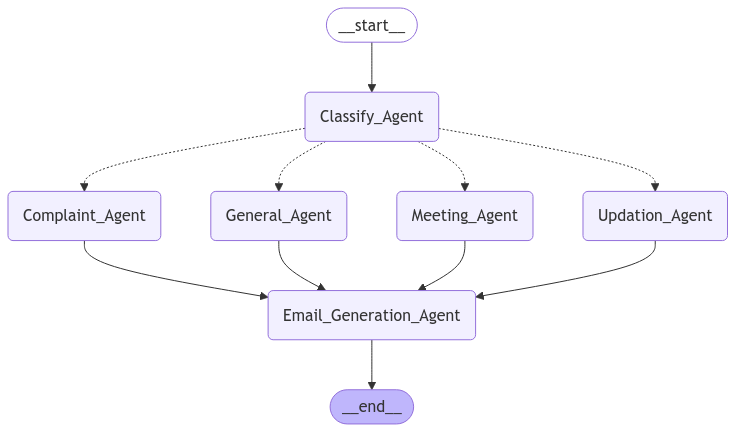

In [ ]:
from langgraph.graph.state import CompiledStateGraph
graph: CompiledStateGraph = builder.compile()
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
user_query = 'Write a simple report on how to use Generative AI in Healthcare Sector.'
sys_prompt_classify = "Your system prompt goes here"  # Replace with your actual system prompt

ai_message = classify_agent(user_query, sys_prompt_classify)
print(ai_message.content)


AttributeError: 'dict' object has no attribute 'messages'

In [ ]:
# Define the user query
user_query = "Your user query here"

# Create the initial messages
initial_messages = [
    SystemMessage(content=sys_prompt_classify),
    HumanMessage(content=user_query)
]

# Create the state with the initial messages
state = MessagesState(messages=initial_messages)

# Invoke the graph with the state
response = graph.invoke(state)

# Access the response content
response_content = response['messages'][-1].content
print(response_content)


KeyError: 'user_query'

In [ ]:
# Assuming sys_prompt_classify is defined as you had it in your previous code
user_query = 'Write a simple report on how to use Generative AI in Healthcare Sector.'
output = graph.invoke({'user_query': user_query})

InvalidUpdateError: Must write to at least one of ['messages']

In [ ]:
# Assuming sys_prompt_classify is defined as you had it in your previous code
user_query = 'Write a simple report on how to use Generative AI in Healthcare Sector.'

# Create the initial messages
initial_messages = [
    SystemMessage(content=sys_prompt_classify),  # Include the system prompt
    HumanMessage(content=user_query)
]

# Create the state with the initial messages
state = MessagesState(messages=initial_messages)  # Create a MessagesState object

# Invoke the graph with the state, not just the user_query
# Pass user_query as input instead of state
output = graph.invoke({'user_query': user_query})

# Access the response content
response_content = output['messages'][-1].content
print(response_content)

InvalidUpdateError: Must write to at least one of ['messages']